In [1]:
from google.colab import files
uploaded= files.upload()

Saving final_burn_dataset_for_colab.zip to final_burn_dataset_for_colab.zip


In [2]:
import zipfile
import os

zip_path = '/content/final_burn_dataset_for_colab.zip'
output_dir = '/content/' # התיקייה שבה הנתונים יחולצו

print(f"פותח את קובץ ה-ZIP: {zip_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print("הנתונים נחלצו בהצלחה ל- /content/final_burn_dataset/")
# לוודא שהנתיבים ש-Colab יצר נכונים
if os.path.exists(os.path.join(output_dir, "final_burn_dataset", "train", "train_images")):
    print("מבנה התיקיות תקין.")
else:
    print("אזהרה: מבנה התיקיות שונה מהצפוי. אנא וודאי את הנתיבים.")

פותח את קובץ ה-ZIP: /content/final_burn_dataset_for_colab.zip...
הנתונים נחלצו בהצלחה ל- /content/final_burn_dataset/
מבנה התיקיות תקין.


In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import warnings
from torchvision import transforms as T

# הסתרת אזהרות מיותרות מ-Pillow
warnings.filterwarnings("ignore", category=UserWarning, module="PIL")

# --- 1. הגדרות גלובליות ---
ROOT_DIR_TRAIN_IMAGES      = r"/content/final_burn_dataset/train/train_images"
ROOT_DIR_TRAIN_ANNOTATIONS = r"/content/final_burn_dataset/train/train_xmls"
ROOT_DIR_TEST_IMAGES       = r"/content/final_burn_dataset/test/test_images"
ROOT_DIR_TEST_ANNOTATIONS  = r"/content/final_burn_dataset/test/test_xmls"  # ישמש כסט ולידציה

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"משתמש ב- DEVICE: {DEVICE}")

CLASS_MAP = {
    '__background__': 0,
    'degree_1':      1,
    'degree_2':      2,
    'degree_3':      3
}
NUM_CLASSES = len(CLASS_MAP)  # = 4

# --- 2. פונקציות עזר לטיפול בנתונים ---

def get_transform(train):
    if train:
        return T.Compose([
            T.ToTensor(),
            T.RandomHorizontalFlip(0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
            T.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
        ])
    else:
        return T.Compose([ T.ToTensor() ])

def collate_fn(batch):
    return tuple(zip(*batch))

# --- 3. CustomDataset לטעינת נתונים ---
class CustomDataset(Dataset):
    def __init__(self, root_dir_images, root_dir_annotations, transforms=None, class_map=None):
        self.root_dir       = root_dir_images
        self.annotations_dir = root_dir_annotations
        self.transforms     = transforms
        self.class_map      = class_map or CLASS_MAP

        self.image_ids = self._load_and_validate_image_ids()
        print(f"בתיקייה {root_dir_images}: סה\"כ תמונות וביאורים נטענו בהצלחה: {len(self.image_ids)}")

    def _load_and_validate_image_ids(self):
        image_ids = []
        xml_files = [f for f in os.listdir(self.annotations_dir) if f.endswith('.xml')]

        for xml_file_name in xml_files:
            base_name = os.path.splitext(xml_file_name)[0]

            found_img_path = None
            for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
                temp_path = os.path.join(self.root_dir, base_name + ext)
                if os.path.exists(temp_path):
                    found_img_path = temp_path
                    break

            if found_img_path is None:
                print(f"אזהרה: תמונה {base_name} לא נמצאה עבור ביאור {xml_file_name}. מדלג על זוג זה.")
                continue

            image_ids.append(base_name)
        return image_ids

    def __getitem__(self, idx):
        img_id_base = self.image_ids[idx]

        img_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            temp_path = os.path.join(self.root_dir, img_id_base + ext)
            if os.path.exists(temp_path):
                img_path = temp_path
                break

        if img_path is None:
            raise FileNotFoundError(f"קובץ תמונה לא נמצא עבור {img_id_base} עם אף סיומת נפוצה.")

        img = Image.open(img_path).convert("RGB")

        xml_path = os.path.join(self.annotations_dir, img_id_base + '.xml')
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes  = []
        labels = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name not in self.class_map:
                print(f"אזהרה: מחלקה '{name}' לא ממופה ב-CLASS_MAP עבור תמונה {img_id_base}. מדלג על אובייקט זה.")
                continue

            label_id = self.class_map[name]
            bndbox   = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        if len(boxes) == 0:
            boxes  = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes  = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes":    boxes,
            "labels":   labels,
            "image_id": torch.tensor([idx]),
            "area":     (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
                        if len(boxes) > 0
                        else torch.zeros((0,), dtype=torch.float32),
            "iscrowd":  torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

# --- 4. הגדרת המודל ---
def create_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    return model

# --- 5. פונקציות אימון והערכה ---
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    for i, (images, targets) in enumerate(data_loader):
        images  = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses    = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        if i % 10 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}/{len(data_loader)}, Loss: {losses.item():.4f}")
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    # הגדר את המודל למצב אימון באופן זמני כדי לקבל את מילון ההפסדים
    # This is the crucial change
    model.train()
    print("מבצע הערכה על סט הבדיקה...")
    eval_losses = []
    with torch.no_grad(): # עדיין השתמש ב-no_grad מכיוון שאיננו צריכים גרדיאנטים להערכה
        for i, (images, targets) in enumerate(data_loader):
            images  = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # כעת זה יחזיר את loss_dict כי המודל במצב אימון
            loss_dict = model(images, targets)
            losses    = sum(loss for loss in loss_dict.values())
            eval_losses.append(losses.item())

            if i % 50 == 0:
                print(f"Eval Batch {i}/{len(data_loader)}, Loss: {losses.item():.4f}")

    avg_eval_loss = np.mean(eval_losses) if eval_losses else 0
    print(f"הערכה בסיסית הושלמה. ממוצע הפסד ולידציה: {avg_eval_loss:.4f}")

    # החזר את המודל למצב eval() לאחר חישוב הפסד הוולידציה
    model.eval()
    return avg_eval_loss

# def evaluate(model, data_loader, device):
#     model.eval()
#     print("מבצע הערכה על סט הבדיקה...")
#     eval_losses = []
#     with torch.no_grad():
#         for i, (images, targets) in enumerate(data_loader):
#             images  = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             loss_dict = model(images, targets)
#             losses    = sum(loss for loss in loss_dict.values())
#             eval_losses.append(losses.item())

#             if i % 50 == 0:
#                 print(f"Eval Batch {i}/{len(data_loader)}, Loss: {losses.item():.4f}")

#     avg_eval_loss = np.mean(eval_losses) if eval_losses else 0
#     print(f"הערכה בסיסית הושלמה. ממוצע הפסד ולידציה: {avg_eval_loss:.4f}")
#     return avg_eval_loss

# --- 6. מחלקת EarlyStopping ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience   = patience
        self.min_delta  = min_delta
        self.counter    = 0
        self.best_loss  = None
        self.early_stop = False

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter   = 0
            return False
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} מתוך {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
            return False

# --- 7. פונקציית MAIN להרצת תהליך האימון ובהסקה ---
def main():
    # טעינת נתוני אימון
    print("טוען נתוני אימון...")
    dataset_train = CustomDataset(
        root_dir_images=ROOT_DIR_TRAIN_IMAGES,
        root_dir_annotations=ROOT_DIR_TRAIN_ANNOTATIONS,
        transforms=get_transform(train=True),
        class_map=CLASS_MAP
    )

    # טעינת נתוני ולידציה
    print("טוען נתוני בדיקה...")
    dataset_val = CustomDataset(
        root_dir_images=ROOT_DIR_TEST_IMAGES,
        root_dir_annotations=ROOT_DIR_TEST_ANNOTATIONS,
        transforms=get_transform(train=False),
        class_map=CLASS_MAP
    )

    data_loader_train = DataLoader(
        dataset_train, batch_size=4, shuffle=True,
        num_workers=2, collate_fn=collate_fn
    )
    data_loader_val = DataLoader(
        dataset_val, batch_size=4, shuffle=False,
        num_workers=2, collate_fn=collate_fn
    )

    # יצירת המודל
    print("יוצר מודל...")
    model = create_fasterrcnn_model(NUM_CLASSES)
    model.to(DEVICE)

    # הגדרת אופטימייזר ולומד קצב
    params    = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    # הגדרת EarlyStopping ומשתנה לשמירת המודל הטוב ביותר
    early_stopping  = EarlyStopping(patience=5, min_delta=0.001)
    NUM_EPOCHS      = 30
    best_val_loss   = float('inf')
    best_model_path = "best_fasterrcnn_model.pth"

    # לולאת אימון + ולידציה
    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\n---- אפוק {epoch} ----")
        train_loss = train_one_epoch(model, optimizer, data_loader_train, DEVICE, epoch)
        print(f"איבוד באימון (Epoch {epoch}): {train_loss:.4f}")

        val_loss = evaluate(model, data_loader_val, DEVICE)
        print(f"איבוד ולידציה (Epoch {epoch}): {val_loss:.4f}")

        lr_scheduler.step()

        # שמירת המודל הטוב ביותר לפי ולידציה
        if val_loss < best_val_loss:
            print(f"שומר מודל טוב יותר! איבוד ולידציה ירד מ-{best_val_loss:.4f} ל-{val_loss:.4f}")
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        # בדיקת EarlyStopping
        if early_stopping.step(val_loss):
            print(f"עצירת אימון מוקדמת באפוק {epoch} עקב חוסר שיפור באיבוד ולידציה")
            break

    print(f"\nאימון הושלם. המודל הטוב ביותר נשמר ב-{best_model_path}")

    # שלב הסקה על תמונה מסט הוולידציה (דוגמה אקראית)
    print("\n--- מבצע הסקה על תמונת בדיקה אקראית מסט הוולידציה ---")
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    def visualize_and_infer(model, image_path, class_map, score_threshold=0.7):
        rev_class_map = {v: k for k, v in class_map.items()}
        img_orig = Image.open(image_path).convert("RGB")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        img_tensor = transform(img_orig).to(DEVICE)

        with torch.no_grad():
            prediction = model([img_tensor])

        boxes  = prediction[0]['boxes'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()

        draw = ImageDraw.Draw(img_orig)
        font_path = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"
        try:
            if not os.path.exists(font_path):
                font = ImageFont.load_default()
            else:
                font = ImageFont.truetype(font_path, 20)
        except Exception:
            font = ImageFont.load_default()

        detected_objects = []
        for box, label, score in zip(boxes, labels, scores):
            if score > score_threshold and rev_class_map.get(label) != '__background__':
                x_min, y_min, x_max, y_max = box.astype(int)
                label_name = rev_class_map.get(label, "Unknown")

                draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=3)
                text_to_display = f"{label_name}: {score:.2f}"
                bbox_text = draw.textbbox((x_min, y_min), text_to_display, font=font)
                text_width  = bbox_text[2] - bbox_text[0]
                text_height = bbox_text[3] - bbox_text[1]
                draw.rectangle([(x_min, y_min), (x_min + text_width, y_min + text_height)], fill="white")
                draw.text((x_min, y_min), text_to_display, fill="black", font=font)

                detected_objects.append({
                    "label": label_name,
                    "score": float(score),
                    "box": [int(x_min), int(y_min), int(x_max), int(y_max)]
                })

        output_filename   = os.path.basename(image_path).split('.')[0] + "_detected.jpg"
        output_image_path = os.path.join("/content/", output_filename)
        img_orig.save(output_image_path)
        print(f"התמונה עם הזיהויים נשמרה ב: {output_image_path}")

        return detected_objects

    # בודקים אם יש תמונות בסט הוולידציה
    if dataset_val.image_ids:
        example_image_base_name = dataset_val.image_ids[0]
        example_image_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            temp_path = os.path.join(ROOT_DIR_TEST_IMAGES, example_image_base_name + ext)
            if os.path.exists(temp_path):
                example_image_path = temp_path
                break

        if example_image_path:
            print(f"מבצע הסקה על התמונה: {example_image_path}")
            detections = visualize_and_infer(model, example_image_path, CLASS_MAP, score_threshold=0.7)
            if detections:
                print("אובייקטים שזוהו:")
                for det in detections:
                    print(f"   מחלקה: {det['label']}, ציון: {det['score']:.2f}, תיבה: {det['box']}")
            else:
                print("לא זוהו אובייקטים בסף הציון הנתון.")
        else:
            print("שגיאה: לא נמצאה תמונה לדוגמה בתיקיית הוולידציה.")
    else:
        print("אין תמונות בסט הוולידציה לביצוע הסקה.")

if __name__ == '__main__':
    main()


משתמש ב- DEVICE: cuda
טוען נתוני אימון...
בתיקייה /content/final_burn_dataset/train/train_images: סה"כ תמונות וביאורים נטענו בהצלחה: 981
טוען נתוני בדיקה...
בתיקייה /content/final_burn_dataset/test/test_images: סה"כ תמונות וביאורים נטענו בהצלחה: 246
יוצר מודל...

---- אפוק 1 ----
Epoch: 1, Iteration: 0/246, Loss: 1.7292
Epoch: 1, Iteration: 10/246, Loss: 0.4844
Epoch: 1, Iteration: 20/246, Loss: 0.2477
Epoch: 1, Iteration: 30/246, Loss: 0.5948
Epoch: 1, Iteration: 40/246, Loss: 0.1637
Epoch: 1, Iteration: 50/246, Loss: 0.3400
Epoch: 1, Iteration: 60/246, Loss: 0.4931
Epoch: 1, Iteration: 70/246, Loss: 0.4966
Epoch: 1, Iteration: 80/246, Loss: 0.3154
Epoch: 1, Iteration: 90/246, Loss: 0.5625
Epoch: 1, Iteration: 100/246, Loss: 0.3391
Epoch: 1, Iteration: 110/246, Loss: 0.3841
Epoch: 1, Iteration: 120/246, Loss: 0.4507
Epoch: 1, Iteration: 130/246, Loss: 0.3943
Epoch: 1, Iteration: 140/246, Loss: 0.4068
Epoch: 1, Iteration: 150/246, Loss: 0.5121
Epoch: 1, Iteration: 160/246, Loss: 0.2905

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(model, dataset, device, num_images=5, score_threshold=0.5):
    model.eval()
    for idx in range(num_images):
        img, target = dataset[idx]
        img_tensor = img.to(device).unsqueeze(0)
        with torch.no_grad():
            output = model(img_tensor)[0]

        img_np = img.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(8, 8))
        plt.imshow(img_np)
        ax = plt.gca()

        # ניבויים
        for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
            if score < score_threshold:
                continue
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            class_name = list(CLASS_MAP.keys())[list(CLASS_MAP.values()).index(label.item())]
            ax.text(xmin, ymin - 5, f"{class_name} {score:.2f}", color='white',
                    bbox=dict(facecolor='red', alpha=0.5))

        # תיבות אמת (GT)
        for box, label in zip(target['boxes'], target['labels']):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=1.5, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            class_name = list(CLASS_MAP.keys())[list(CLASS_MAP.values()).index(label.item())]
            ax.text(xmin, ymax + 10, f"{class_name} (GT)", color='green',
                    bbox=dict(facecolor='black', alpha=0.3))

        plt.axis('off')
        plt.title(f"Image {idx+1} Predictions (red) and GT (green)")
        plt.show()


משתמש ב- DEVICE: cuda
טוען נתוני אימון...
בתיקייה /content/final_burn_dataset/train/train_images: סה"כ תמונות וביאורים נטענו בהצלחה: 981
טוען נתוני בדיקה...
בתיקייה /content/final_burn_dataset/test/test_images: סה"כ תמונות וביאורים נטענו בהצלחה: 246
יוצר מודל...


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 175MB/s]



---- אפוק 1 ----
Epoch: 1, Iteration: 0/246, Loss: 1.9182
Epoch: 1, Iteration: 10/246, Loss: 0.4975
Epoch: 1, Iteration: 20/246, Loss: 0.2383
Epoch: 1, Iteration: 30/246, Loss: 0.3707
Epoch: 1, Iteration: 40/246, Loss: 0.5037
Epoch: 1, Iteration: 50/246, Loss: 0.4096
Epoch: 1, Iteration: 60/246, Loss: 0.3435
Epoch: 1, Iteration: 70/246, Loss: 0.2266
Epoch: 1, Iteration: 80/246, Loss: 0.2396
Epoch: 1, Iteration: 90/246, Loss: 0.5107
Epoch: 1, Iteration: 100/246, Loss: 0.4743
Epoch: 1, Iteration: 110/246, Loss: 0.6030
Epoch: 1, Iteration: 120/246, Loss: 0.3450
Epoch: 1, Iteration: 130/246, Loss: 0.2724
Epoch: 1, Iteration: 140/246, Loss: 0.2537
Epoch: 1, Iteration: 150/246, Loss: 0.4586
Epoch: 1, Iteration: 160/246, Loss: 0.3578
Epoch: 1, Iteration: 170/246, Loss: 0.4562
Epoch: 1, Iteration: 180/246, Loss: 0.4250
Epoch: 1, Iteration: 190/246, Loss: 0.4908
Epoch: 1, Iteration: 200/246, Loss: 0.2429
Epoch: 1, Iteration: 210/246, Loss: 0.3587
Epoch: 1, Iteration: 220/246, Loss: 0.2642
Epoc

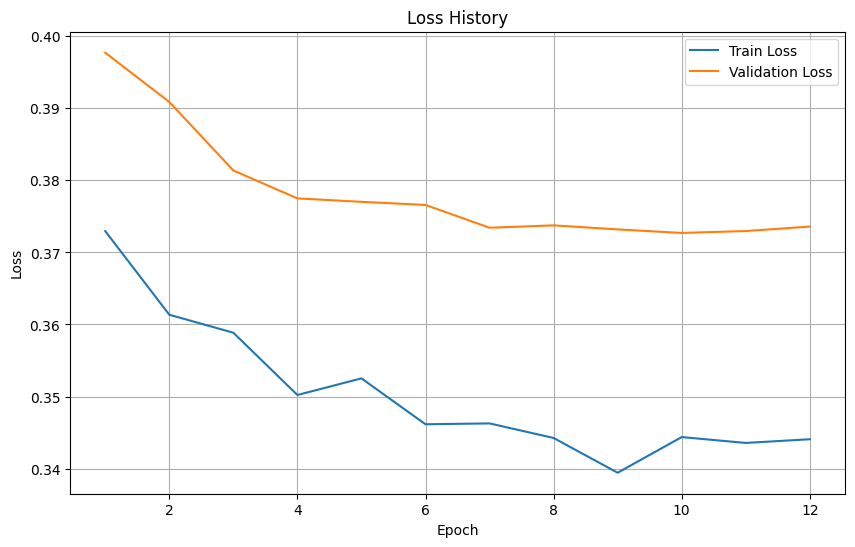

תרשים Loss נשמר ב- /content/loss_history.png

--- אוסף תחזיות עבור מטריצת בלבול מסט הוולידציה ---


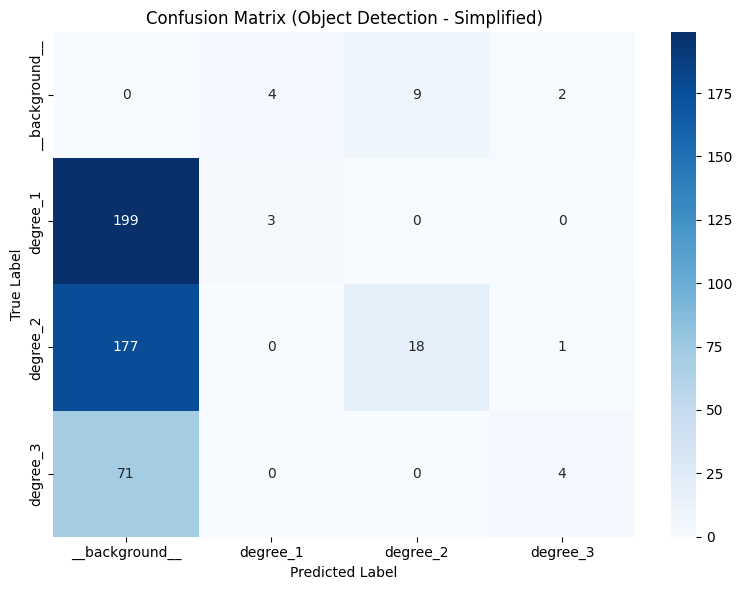

מטריצת בלבול נשמרה ב- /content/confusion_matrix.png

הערה לגבי מטריצת הבלבול: 
  שורות מייצגות תוויות אמיתיות, עמודות מייצגות תוויות צפויות.
  האלכסון הראשי הוא זיהויים נכונים (True Positives).
  שורה X, עמודה Y: כמה פעמים אובייקט אמיתי ממחלקה X זוהה בטעות כמחלקה Y.
  מחלקה '__background__': אובייקט אמיתי סווג כרקע (False Negative), או רקע סווג כאובייקט (False Positive).
  זוהי מטריצה פשטנית שאינה מחשבת IoU באופן מלא כמו mAP.

--- מבצע הסקה על תמונת בדיקה אקראית מסט הוולידציה ---
מבצע הסקה על התמונה: /content/final_burn_dataset/test/test_images/img152.jpg
התמונה עם הזיהויים נשמרה ב: /content/img152_detected.jpg
לא זוהו אובייקטים בסף הציון הנתון.


In [3]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import warnings
from torchvision import transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# הסתרת אזהרות מיותרות מ-Pillow
warnings.filterwarnings("ignore", category=UserWarning, module="PIL")

# --- 1. הגדרות גלובליות ---
ROOT_DIR_TRAIN_IMAGES      = r"/content/final_burn_dataset/train/train_images"
ROOT_DIR_TRAIN_ANNOTATIONS = r"/content/final_burn_dataset/train/train_xmls"
ROOT_DIR_TEST_IMAGES       = r"/content/final_burn_dataset/test/test_images"
ROOT_DIR_TEST_ANNOTATIONS  = r"/content/final_burn_dataset/test/test_xmls"  # ישמש כסט ולידציה

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"משתמש ב- DEVICE: {DEVICE}")

CLASS_MAP = {
    '__background__': 0,
    'degree_1':      1,
    'degree_2':      2,
    'degree_3':      3
}
NUM_CLASSES = len(CLASS_MAP)  # = 4
REVERSE_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()} # למטרות תצוגה

# --- 2. פונקציות עזר לטיפול בנתונים ---

def get_transform(train):
    if train:
        return T.Compose([
            T.ToTensor(),
            T.RandomHorizontalFlip(0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
            T.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
        ])
    else:
        return T.Compose([ T.ToTensor() ])

def collate_fn(batch):
    return tuple(zip(*batch))

# --- 3. CustomDataset לטעינת נתונים ---
class CustomDataset(Dataset):
    def __init__(self, root_dir_images, root_dir_annotations, transforms=None, class_map=None):
        self.root_dir       = root_dir_images
        self.annotations_dir = root_dir_annotations
        self.transforms     = transforms
        self.class_map      = class_map or CLASS_MAP

        self.image_ids = self._load_and_validate_image_ids()
        print(f"בתיקייה {root_dir_images}: סה\"כ תמונות וביאורים נטענו בהצלחה: {len(self.image_ids)}")

    def _load_and_validate_image_ids(self):
        image_ids = []
        xml_files = [f for f in os.listdir(self.annotations_dir) if f.endswith('.xml')]

        for xml_file_name in xml_files:
            base_name = os.path.splitext(xml_file_name)[0]

            found_img_path = None
            for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
                temp_path = os.path.join(self.root_dir, base_name + ext)
                if os.path.exists(temp_path):
                    found_img_path = temp_path
                    break

            if found_img_path is None:
                print(f"אזהרה: תמונה {base_name} לא נמצאה עבור ביאור {xml_file_name}. מדלג על זוג זה.")
                continue

            image_ids.append(base_name)
        return image_ids

    def __getitem__(self, idx):
        img_id_base = self.image_ids[idx]

        img_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            temp_path = os.path.join(self.root_dir, img_id_base + ext)
            if os.path.exists(temp_path):
                img_path = temp_path
                break

        if img_path is None:
            raise FileNotFoundError(f"קובץ תמונה לא נמצא עבור {img_id_base} עם אף סיומת נפוצה.")

        img = Image.open(img_path).convert("RGB")

        xml_path = os.path.join(self.annotations_dir, img_id_base + '.xml')
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes  = []
        labels = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name not in self.class_map:
                print(f"אזהרה: מחלקה '{name}' לא ממופה ב-CLASS_MAP עבור תמונה {img_id_base}. מדלג על אובייקט זה.")
                continue

            label_id = self.class_map[name]
            bndbox   = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        if len(boxes) == 0:
            boxes  = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes  = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes":    boxes,
            "labels":   labels,
            "image_id": torch.tensor([idx]),
            "area":     (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
                        if len(boxes) > 0
                        else torch.zeros((0,), dtype=torch.float32),
            "iscrowd":  torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

# --- 4. הגדרת המודל ---
def create_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    return model

# --- 5. פונקציות אימון והערכה ---
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    for i, (images, targets) in enumerate(data_loader):
        images  = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses    = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        if i % 10 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}/{len(data_loader)}, Loss: {losses.item():.4f}")
    return total_loss / len(data_loader)

# פונקציית הערכה מעודכנת - תחזיר גם תחזיות ומטרות
def evaluate(model, data_loader, device, iou_threshold=0.5, score_threshold=0.05): # הוספתי סף ציון נמוך יותר לתחזיות למטריצת בלבול
    model.train() # מחזיר למצב אימון כדי לקבל את ה-loss_dict
    print("מבצע הערכה על סט הבדיקה...")
    eval_losses = []
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            images  = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # חישוב Loss (כמו באימון)
            loss_dict = model(images, targets)
            losses    = sum(loss for loss in loss_dict.values())
            eval_losses.append(losses.item())

            # מעבר למצב eval כדי לקבל תחזיות (לא לצורך חישוב Loss)
            # נבצע את זה בנפרד כי לא ניתן לקבל loss וגם תחזיות בו זמנית מהמודל באותה קריאה
            model.eval() # זמנית למצב הערכה
            predictions = model(images)
            model.train() # חזרה למצב אימון עבור ה-loss_dict הבא

            for j in range(len(images)): # עובר על כל תמונה בבאצ'
                gt_labels = targets[j]['labels'].cpu().numpy()
                gt_boxes  = targets[j]['boxes'].cpu().numpy()

                pred_boxes  = predictions[j]['boxes'].cpu().numpy()
                pred_labels = predictions[j]['labels'].cpu().numpy()
                pred_scores = predictions[j]['scores'].cpu().numpy()

                # מסנן תחזיות לפי סף ביטחון
                high_conf_indices = np.where(pred_scores >= score_threshold)[0]
                pred_boxes  = pred_boxes[high_conf_indices]
                pred_labels = pred_labels[high_conf_indices]
                pred_scores = pred_scores[high_conf_indices]

                # חישוב IoU ומציאת התאמות
                matched_preds = np.zeros(len(pred_boxes), dtype=bool) # מסמן אילו תחזיות כבר תואמות

                # תווית רקע עבור FP (כשאנו מזהים משהו שאין לו התאמה אמיתית)
                background_label = CLASS_MAP['__background__']

                for gt_idx, gt_box in enumerate(gt_boxes):
                    gt_label = gt_labels[gt_idx]

                    found_match = False
                    best_iou = 0
                    best_pred_idx = -1

                    for pred_idx, pred_box in enumerate(pred_boxes):
                        if matched_preds[pred_idx]: # אם התחזית כבר תואמת, דלג
                            continue

                        iou = calculate_iou(gt_box, pred_box)
                        if iou > best_iou and iou >= iou_threshold:
                            best_iou = iou
                            best_pred_idx = pred_idx

                    if best_pred_idx != -1:
                        # מצאנו התאמה
                        predicted_class = pred_labels[best_pred_idx]
                        all_true_labels.append(gt_label)
                        all_pred_labels.append(predicted_class)
                        matched_preds[best_pred_idx] = True # סמן כתואם
                        found_match = True
                    else:
                        # FN - אובייקט אמיתי שלא זוהה
                        all_true_labels.append(gt_label)
                        all_pred_labels.append(background_label) # או תווית "אין זיהוי"

                # FP - תחזיות שלא תאמו אף תיבת אמת
                for pred_idx, pred_box in enumerate(pred_boxes):
                    if not matched_preds[pred_idx]:
                        # תחזית שאין לה התאמה אמיתית, לכן היא FP
                        predicted_class = pred_labels[pred_idx]
                        all_true_labels.append(background_label) # האמת היא רקע
                        all_pred_labels.append(predicted_class) # המודל זיהה כ-predicted_class

            if i % 50 == 0:
                print(f"Eval Batch {i}/{len(data_loader)}, Loss: {losses.item():.4f}")

    avg_eval_loss = np.mean(eval_losses) if eval_losses else 0
    print(f"הערכה בסיסית הושלמה. ממוצע הפסד ולידציה: {avg_eval_loss:.4f}")

    model.eval() # החזר את המודל למצב eval() בסיום
    return avg_eval_loss, all_true_labels, all_pred_labels

# פונקציית עזר לחישוב IoU
def calculate_iou(box1, box2):
    # box1 and box2 are [xmin, ymin, xmax, ymax]
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    # Calculate intersection coordinates
    inter_xmin = max(xmin1, xmin2)
    inter_ymin = max(ymin1, ymin2)
    inter_xmax = min(xmax1, xmax2)
    inter_ymax = min(ymax1, ymax2)

    inter_width = max(0, inter_xmax - inter_xmin)
    inter_height = max(0, inter_ymax - inter_ymin)
    intersection_area = inter_width * inter_height

    box1_area = (xmax1 - xmin1) * (ymax1 - ymin1)
    box2_area = (xmax2 - xmin2) * (ymax2 - ymin2)

    union_area = box1_area + box2_area - intersection_area

    if union_area == 0:
        return 0.0
    return intersection_area / union_area

# --- 6. מחלקת EarlyStopping ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience   = patience
        self.min_delta  = min_delta
        self.counter    = 0
        self.best_loss  = None
        self.early_stop = False

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter   = 0
            return False
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} מתוך {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
            return False

# --- 7. פונקציית MAIN להרצת תהליך האימון ובהסקה ---
def main():
    # טעינת נתוני אימון
    print("טוען נתוני אימון...")
    dataset_train = CustomDataset(
        root_dir_images=ROOT_DIR_TRAIN_IMAGES,
        root_dir_annotations=ROOT_DIR_TRAIN_ANNOTATIONS,
        transforms=get_transform(train=True),
        class_map=CLASS_MAP
    )

    # טעינת נתוני ולידציה
    print("טוען נתוני בדיקה...")
    dataset_val = CustomDataset(
        root_dir_images=ROOT_DIR_TEST_IMAGES,
        root_dir_annotations=ROOT_DIR_TEST_ANNOTATIONS,
        transforms=get_transform(train=False),
        class_map=CLASS_MAP
    )

    data_loader_train = DataLoader(
        dataset_train, batch_size=4, shuffle=True,
        num_workers=2, collate_fn=collate_fn
    )
    data_loader_val = DataLoader(
        dataset_val, batch_size=4, shuffle=False,
        num_workers=2, collate_fn=collate_fn
    )

    # יצירת המודל
    print("יוצר מודל...")
    model = create_fasterrcnn_model(NUM_CLASSES)
    model.to(DEVICE)

    # הגדרת אופטימייזר ולומד קצב
    params    = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    # הגדרת EarlyStopping ומשתנה לשמירת המודל הטוב ביותר
    early_stopping  = EarlyStopping(patience=5, min_delta=0.001)
    NUM_EPOCHS      = 30
    best_val_loss   = float('inf')
    best_model_path = "best_fasterrcnn_model.pth"

    # רשימות לשמירת נתוני ה-Loss עבור גרפים
    train_losses_history = []
    val_losses_history = []

    # לולאת אימון + ולידציה
    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\n---- אפוק {epoch} ----")
        train_loss = train_one_epoch(model, optimizer, data_loader_train, DEVICE, epoch)
        train_losses_history.append(train_loss)
        print(f"איבוד באימון (Epoch {epoch}): {train_loss:.4f}")

        # הערכה על סט ולידציה (תחזיר גם את התוויות האמיתיות והתחזיות)
        val_loss, all_true_labels, all_pred_labels = evaluate(model, data_loader_val, DEVICE)
        val_losses_history.append(val_loss)
        print(f"איבוד ולידציה (Epoch {epoch}): {val_loss:.4f}")

        lr_scheduler.step()

        # שמירת המודל הטוב ביותר לפי ולידציה
        if val_loss < best_val_loss:
            print(f"שומר מודל טוב יותר! איבוד ולידציה ירד מ-{best_val_loss:.4f} ל-{val_loss:.4f}")
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        # בדיקת EarlyStopping
        if early_stopping.step(val_loss):
            print(f"עצירת אימון מוקדמת באפוק {epoch} עקב חוסר שיפור באיבוד ולידציה")
            break

    print(f"\nאימון הושלם. המודל הטוב ביותר נשמר ב-{best_model_path}")

    # --- יצירת תרשימי PLOT ל-Loss ---
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_history) + 1), train_losses_history, label='Train Loss')
    plt.plot(range(1, len(val_losses_history) + 1), val_losses_history, label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/loss_history.png')
    plt.show()
    print("תרשים Loss נשמר ב- /content/loss_history.png")

    # --- יצירת מטריצת בלבול (Confusion Matrix) ---
    # נטען את המודל הטוב ביותר ונבצע הערכה סופית כדי לאסוף את כל התחזיות
    print("\n--- אוסף תחזיות עבור מטריצת בלבול מסט הוולידציה ---")
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval() # במצב זה אנחנו רק רוצים תחזיות, לא לחשב loss

    # הפונקציה evaluate עודכנה כדי להחזיר גם את all_true_labels ו-all_pred_labels
    # אבל כאן אנחנו צריכים רק את התחזיות, אז נשתמש ב-evaluate_for_confusion_matrix

    final_true_labels = []
    final_pred_labels = []

    # נגדיר את זה כפונקציה נפרדת כי evaluate משתמשת ב-model.train() באופן זמני,
    # וזה לא מה שאנחנו רוצים עבור איסוף נתונים מדויק למטריצת בלבול.
    # אנחנו צריכים את המודל להיות במצב eval() אמיתי עבור איסוף תחזיות.

    def collect_predictions_for_confusion_matrix(model, data_loader, device, iou_threshold=0.5, score_threshold=0.05):
        model.eval()
        true_labels_flat = []
        pred_labels_flat = []

        with torch.no_grad():
            for i, (images, targets) in enumerate(data_loader):
                images = list(image.to(device) for image in images)

                # המודל במצב eval() מחזיר תחזיות
                predictions = model(images)

                for j in range(len(images)): # עובר על כל תמונה בבאצ'
                    gt_labels = targets[j]['labels'].cpu().numpy()
                    gt_boxes  = targets[j]['boxes'].cpu().numpy()

                    pred_boxes  = predictions[j]['boxes'].cpu().numpy()
                    pred_labels = predictions[j]['labels'].cpu().numpy()
                    pred_scores = predictions[j]['scores'].cpu().numpy()

                    # מסנן תחזיות לפי סף ביטחון
                    high_conf_indices = np.where(pred_scores >= score_threshold)[0]
                    pred_boxes  = pred_boxes[high_conf_indices]
                    pred_labels = pred_labels[high_conf_indices]
                    pred_scores = pred_scores[high_conf_indices]

                    matched_preds = np.zeros(len(pred_boxes), dtype=bool)
                    background_label_id = CLASS_MAP['__background__']

                    # True Positives & False Negatives
                    for gt_idx, gt_box in enumerate(gt_boxes):
                        gt_label = gt_labels[gt_idx]

                        best_iou = 0
                        best_pred_idx = -1

                        for pred_idx, pred_box in enumerate(pred_boxes):
                            if matched_preds[pred_idx]:
                                continue

                            iou = calculate_iou(gt_box, pred_box)
                            if iou > best_iou and iou >= iou_threshold:
                                best_iou = iou
                                best_pred_idx = pred_idx

                        if best_pred_idx != -1:
                            # התאמה - TP או FP (סיווג שגוי)
                            predicted_class = pred_labels[best_pred_idx]
                            true_labels_flat.append(gt_label)
                            pred_labels_flat.append(predicted_class)
                            matched_preds[best_pred_idx] = True
                        else:
                            # FN - אובייקט אמיתי שלא זוהה
                            true_labels_flat.append(gt_label)
                            pred_labels_flat.append(background_label_id)

                    # False Positives
                    for pred_idx, pred_box in enumerate(pred_boxes):
                        if not matched_preds[pred_idx]:
                            # תחזית שאין לה התאמה אמיתית
                            predicted_class = pred_labels[pred_idx]
                            true_labels_flat.append(background_label_id)
                            pred_labels_flat.append(predicted_class)

        return np.array(true_labels_flat), np.array(pred_labels_flat)

    final_true_labels, final_pred_labels = collect_predictions_for_confusion_matrix(
        model, data_loader_val, DEVICE, iou_threshold=0.5, score_threshold=0.7 # השתמשו בסף הסקה רגיל כאן
    )

    # אם אין תחזיות או תוויות אמיתיות, לא ניתן ליצור מטריצת בלבול
    if len(final_true_labels) == 0 or len(final_pred_labels) == 0:
        print("אין מספיק נתונים (תוויות אמיתיות או תחזיות) ליצירת מטריצת בלבול. ייתכן שהמודל לא זיהה דבר או שסט הוולידציה ריק מאובייקטים.")
    else:
        # יצירת מטריצת בלבול
        # וודא שכל המחלקות (כולל רקע) נמצאות במטריצה, גם אם לא הופיעו
        labels_in_cm = sorted(list(set(final_true_labels) | set(final_pred_labels)))
        # אם יש מחלקות חסרות (למשל, רקע אם אין FP או FN של רקע)
        all_possible_labels = sorted(list(CLASS_MAP.values()))
        labels_for_cm = [label for label in all_possible_labels if label in labels_in_cm or label == CLASS_MAP['__background__']]

        # אם המחלקה '__background__' לא מופיעה ב-labels_for_cm, הוסף אותה
        if CLASS_MAP['__background__'] not in labels_for_cm:
            labels_for_cm.insert(0, CLASS_MAP['__background__'])
        labels_for_cm = sorted(list(set(labels_for_cm))) # לוודא ייחודיות וסדר

        cm = confusion_matrix(final_true_labels, final_pred_labels, labels=labels_for_cm)
        cm_df = pd.DataFrame(cm,
                             index=[REVERSE_CLASS_MAP[i] for i in labels_for_cm],
                             columns=[REVERSE_CLASS_MAP[i] for i in labels_for_cm])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
        plt.title('Confusion Matrix (Object Detection - Simplified)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig('/content/confusion_matrix.png')
        plt.show()
        print("מטריצת בלבול נשמרה ב- /content/confusion_matrix.png")
        print("\nהערה לגבי מטריצת הבלבול: ")
        print("  שורות מייצגות תוויות אמיתיות, עמודות מייצגות תוויות צפויות.")
        print("  האלכסון הראשי הוא זיהויים נכונים (True Positives).")
        print("  שורה X, עמודה Y: כמה פעמים אובייקט אמיתי ממחלקה X זוהה בטעות כמחלקה Y.")
        print("  מחלקה '__background__': אובייקט אמיתי סווג כרקע (False Negative), או רקע סווג כאובייקט (False Positive).")
        print("  זוהי מטריצה פשטנית שאינה מחשבת IoU באופן מלא כמו mAP.")


    # שלב הסקה על תמונה מסט הוולידציה (דוגמה אקראית)
    print("\n--- מבצע הסקה על תמונת בדיקה אקראית מסט הוולידציה ---")
    # המודל כבר נטען והוגדר ל-eval()

    def visualize_and_infer(model, image_path, class_map, score_threshold=0.7):
        rev_class_map = {v: k for k, v in class_map.items()}
        img_orig = Image.open(image_path).convert("RGB")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        img_tensor = transform(img_orig).to(DEVICE)

        with torch.no_grad():
            prediction = model([img_tensor])

        boxes  = prediction[0]['boxes'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()

        draw = ImageDraw.Draw(img_orig)
        # נסה למצוא פונט במערכת, אחרת השתמש בפונט ברירת מחדל
        font_path = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"
        try:
            if not os.path.exists(font_path):
                font = ImageFont.load_default()
            else:
                font = ImageFont.truetype(font_path, 20)
        except Exception:
            font = ImageFont.load_default()

        detected_objects = []
        for box, label, score in zip(boxes, labels, scores):
            if score > score_threshold and rev_class_map.get(label) != '__background__':
                x_min, y_min, x_max, y_max = box.astype(int)
                label_name = rev_class_map.get(label, "Unknown")

                draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=3)
                text_to_display = f"{label_name}: {score:.2f}"
                # חישוב גודל הטקסט
                try:
                    bbox_text = draw.textbbox((x_min, y_min), text_to_display, font=font)
                    text_width  = bbox_text[2] - bbox_text[0]
                    text_height = bbox_text[3] - bbox_text[1]
                except AttributeError: # For older Pillow versions
                    text_width, text_height = draw.textsize(text_to_display, font=font)

                # Ensure text box is within image bounds
                text_bg_x2 = min(x_min + text_width, img_orig.width)
                text_bg_y2 = min(y_min + text_height, img_orig.height)
                draw.rectangle([(x_min, y_min), (text_bg_x2, text_bg_y2)], fill="white")
                draw.text((x_min, y_min), text_to_display, fill="black", font=font)

                detected_objects.append({
                    "label": label_name,
                    "score": float(score),
                    "box": [int(x_min), int(y_min), int(x_max), int(y_max)]
                })

        output_filename   = os.path.basename(image_path).split('.')[0] + "_detected.jpg"
        output_image_path = os.path.join("/content/", output_filename)
        img_orig.save(output_image_path)
        print(f"התמונה עם הזיהויים נשמרה ב: {output_image_path}")

        return detected_objects

    # בודקים אם יש תמונות בסט הוולידציה
    if dataset_val.image_ids:
        # קח תמונה אקראית לצורך הדגמה
        random_idx = np.random.randint(0, len(dataset_val.image_ids))
        example_image_base_name = dataset_val.image_ids[random_idx]
        example_image_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            temp_path = os.path.join(ROOT_DIR_TEST_IMAGES, example_image_base_name + ext)
            if os.path.exists(temp_path):
                example_image_path = temp_path
                break

        if example_image_path:
            print(f"מבצע הסקה על התמונה: {example_image_path}")
            detections = visualize_and_infer(model, example_image_path, CLASS_MAP, score_threshold=0.7)
            if detections:
                print("אובייקטים שזוהו:")
                for det in detections:
                    print(f"   מחלקה: {det['label']}, ציון: {det['score']:.2f}, תיבה: {det['box']}")
            else:
                print("לא זוהו אובייקטים בסף הציון הנתון.")
        else:
            print("שגיאה: לא נמצאה תמונה לדוגמה בתיקיית הוולידציה.")
    else:
        print("אין תמונות בסט הוולידציה לביצוע הסקה.")

if __name__ == '__main__':
    main()

In [4]:
from google.colab import files
files.download('/content/best_fasterrcnn_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

המודל הורד בהצלחה למחשב שלך.
